In [79]:
import os
import base64
import requests
import io
import json
from openai import OpenAI
from PIL import Image
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from typing import Dict, Tuple
from dotenv import load_dotenv
load_dotenv()

True

In [43]:
client = OpenAI(
    base_url="https://hackathon.radiantai.com/aurum/openai",
    api_key=f"{os.environ['RADIANT_API_KEY']}",
)

In [44]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')
  
def pil_to_base64_jpg(image):
    output_buffer = io.BytesIO()
    image.save(output_buffer, format='JPEG')
    image_bytes = output_buffer.getvalue()
    return base64.b64encode(image_bytes).decode('utf-8')

def resize_image_maintain_aspect(image, target_width):
  target_height = int(image.height * (target_width / image.width))
  # Resize the image while maintaining the aspect ratio
  return image.resize((target_width, target_height))

In [78]:
CLASSES = ["russian tank", "american tank", "russian soldier", "american soldier", "drone", "explosion", "smoke", "fire"]
CLASSES_STR = ", ".join(CLASSES)

def analyze_frame_for_classes(frame: Image):
    model = "gpt-4-turbo"
    prompt = f"""
        Identify if an object from the following categories appears in this photo: {CLASSES_STR}
        Format the json with true/false for each class.
    """
    base64_jpg = pil_to_base64_jpg(frame)

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_jpg}"
                },
                },
            ],
            }
        ],
        response_format={ "type": "json_object" },
        max_tokens=300,
    )

    return json.loads(response.choices[0].message.content)

def map_input_to_classes(input):
    model = "gpt-3.5-turbo"
    prompt = input

    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system",
        "content": f"""
            Your job is to accept fre-form user requests and map them to the applicable output categories, giving true/false
            whether it was requested. Format it as json with true/false as the value
            The categories are: {CLASSES_STR}

            If the request is too ambiguous or doesn't make sense, add a key "too_ambiguous" with a true/false value
            If there is simply not a good category, add a key "no_close_category" with a true/false value
        """},
        {"role": "user", "content": prompt},
    ],
    response_format={ "type": "json_object" },
    )

    return json.loads(response.choices[0].message.content)

CLASSES_STR


'russian tank, american tank, russian soldier, american soldier, drone, explosion, smoke, fire'

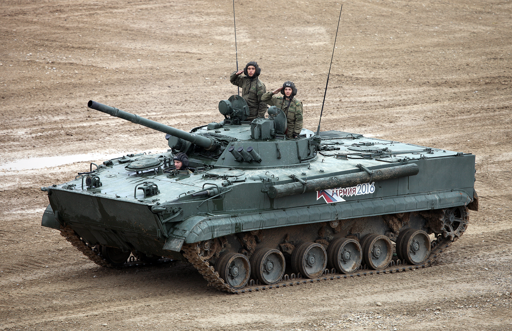

In [52]:
russian_bmp = Image.open("test-data/russian-bmp.jpg")
russian_bmp = resize_image_maintain_aspect(russian_bmp, 512)
russian_bmp

In [53]:
print(analyze_frame_for_classes(russian_bmp))

{'russian tank': True, 'american tank': False, 'russian soldier': True, 'american soldier': False, 'drone': False, 'explosion': False}


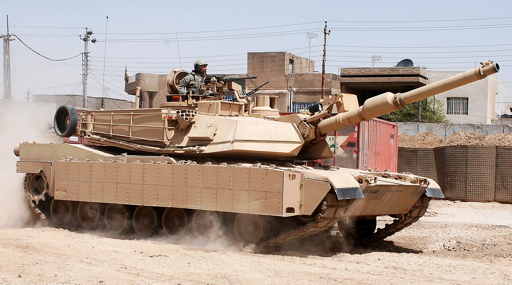

In [54]:
american_abrams = Image.open("test-data/abrams.jpg")
american_abrams = resize_image_maintain_aspect(american_abrams, 512)
american_abrams

In [55]:
print(analyze_frame_for_classes(american_abrams))

{'russian tank': False, 'american tank': True, 'russian soldier': False, 'american soldier': False, 'drone': False, 'explosion': False}


In [56]:
import cv2

In [91]:
class Thumbnail:
    def __init__(self, image, classes):
        self.image = image
        self.classes = classes

    def __repr__(self):
        return f"Thumbnail(image, classes={self.classes})"

class VideoReader:
    def __init__(self, video_path):
        if not os.path.exists(video_path):
            raise ValueError(f"Video file {video_path} does not exist")
        self.video_path = video_path
        self.frame_num_to_thumbnail = {}
        self.process()

    def __repr__(self):
        return f"VideoReader(video_path={self.video_path})"
    
    def get_frame_num_to_thumbnail(self):
        return self.frame_num_to_thumbnail

    def process(self, fps=0.2):  # Processing every 5 seconds
        frames = self.extract_frames(fps)
        with Pool(cpu_count()) as pool:
            results = pool.map(query_frame, frames)
        self.frame_num_to_thumbnail = dict(results)

    def extract_frames(self, fps):
        cap = cv2.VideoCapture(self.video_path)
        fps_rate = cap.get(cv2.CAP_PROP_FPS)
        interval = int(fps_rate / fps)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []

        for frame_num in range(0, frame_count, interval):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if not ret:
                break
            frames.append((frame, frame_num))
        
        cap.release()
        return frames

def query_frame(frame_data):
    frame, frame_num = frame_data
    pil_image = Image.frombytes("RGB", (frame.shape[1], frame.shape[0]), cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).tobytes())
    classes = analyze_frame_for_classes(pil_image)
    return frame_num, Thumbnail(pil_image, classes)

import matplotlib.pyplot as plt
import math

def display_thumbnails(frame_num_to_thumbnail, num_cols=4):
    num_frames = len(frame_num_to_thumbnail)
    num_rows = math.ceil(num_frames / num_cols)

    # Adjust the figsize based on the number of columns
    width = 6 * num_cols  # 6 inches per column
    height = 6 * num_rows  # 6 inches per row
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(width, height))
    axes = axes.flatten()
    
    for i, (frame_num, thumbnail) in enumerate(frame_num_to_thumbnail.items()):
        ax = axes[i]
        ax.imshow(thumbnail.image)
        true_classes = [k for k, v in thumbnail.classes.items() if v]
        ax.set_title(f"Frame {frame_num}: {', '.join(true_classes)}")
        ax.axis('off')

    for j in range(i+1, num_rows * num_cols):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()


In [89]:
bmp_videoreader = VideoReader("test-data/russian-bmp2.mp4")
display_thumbnails(bmp_videoreader.get_frame_num_to_thumbnail())

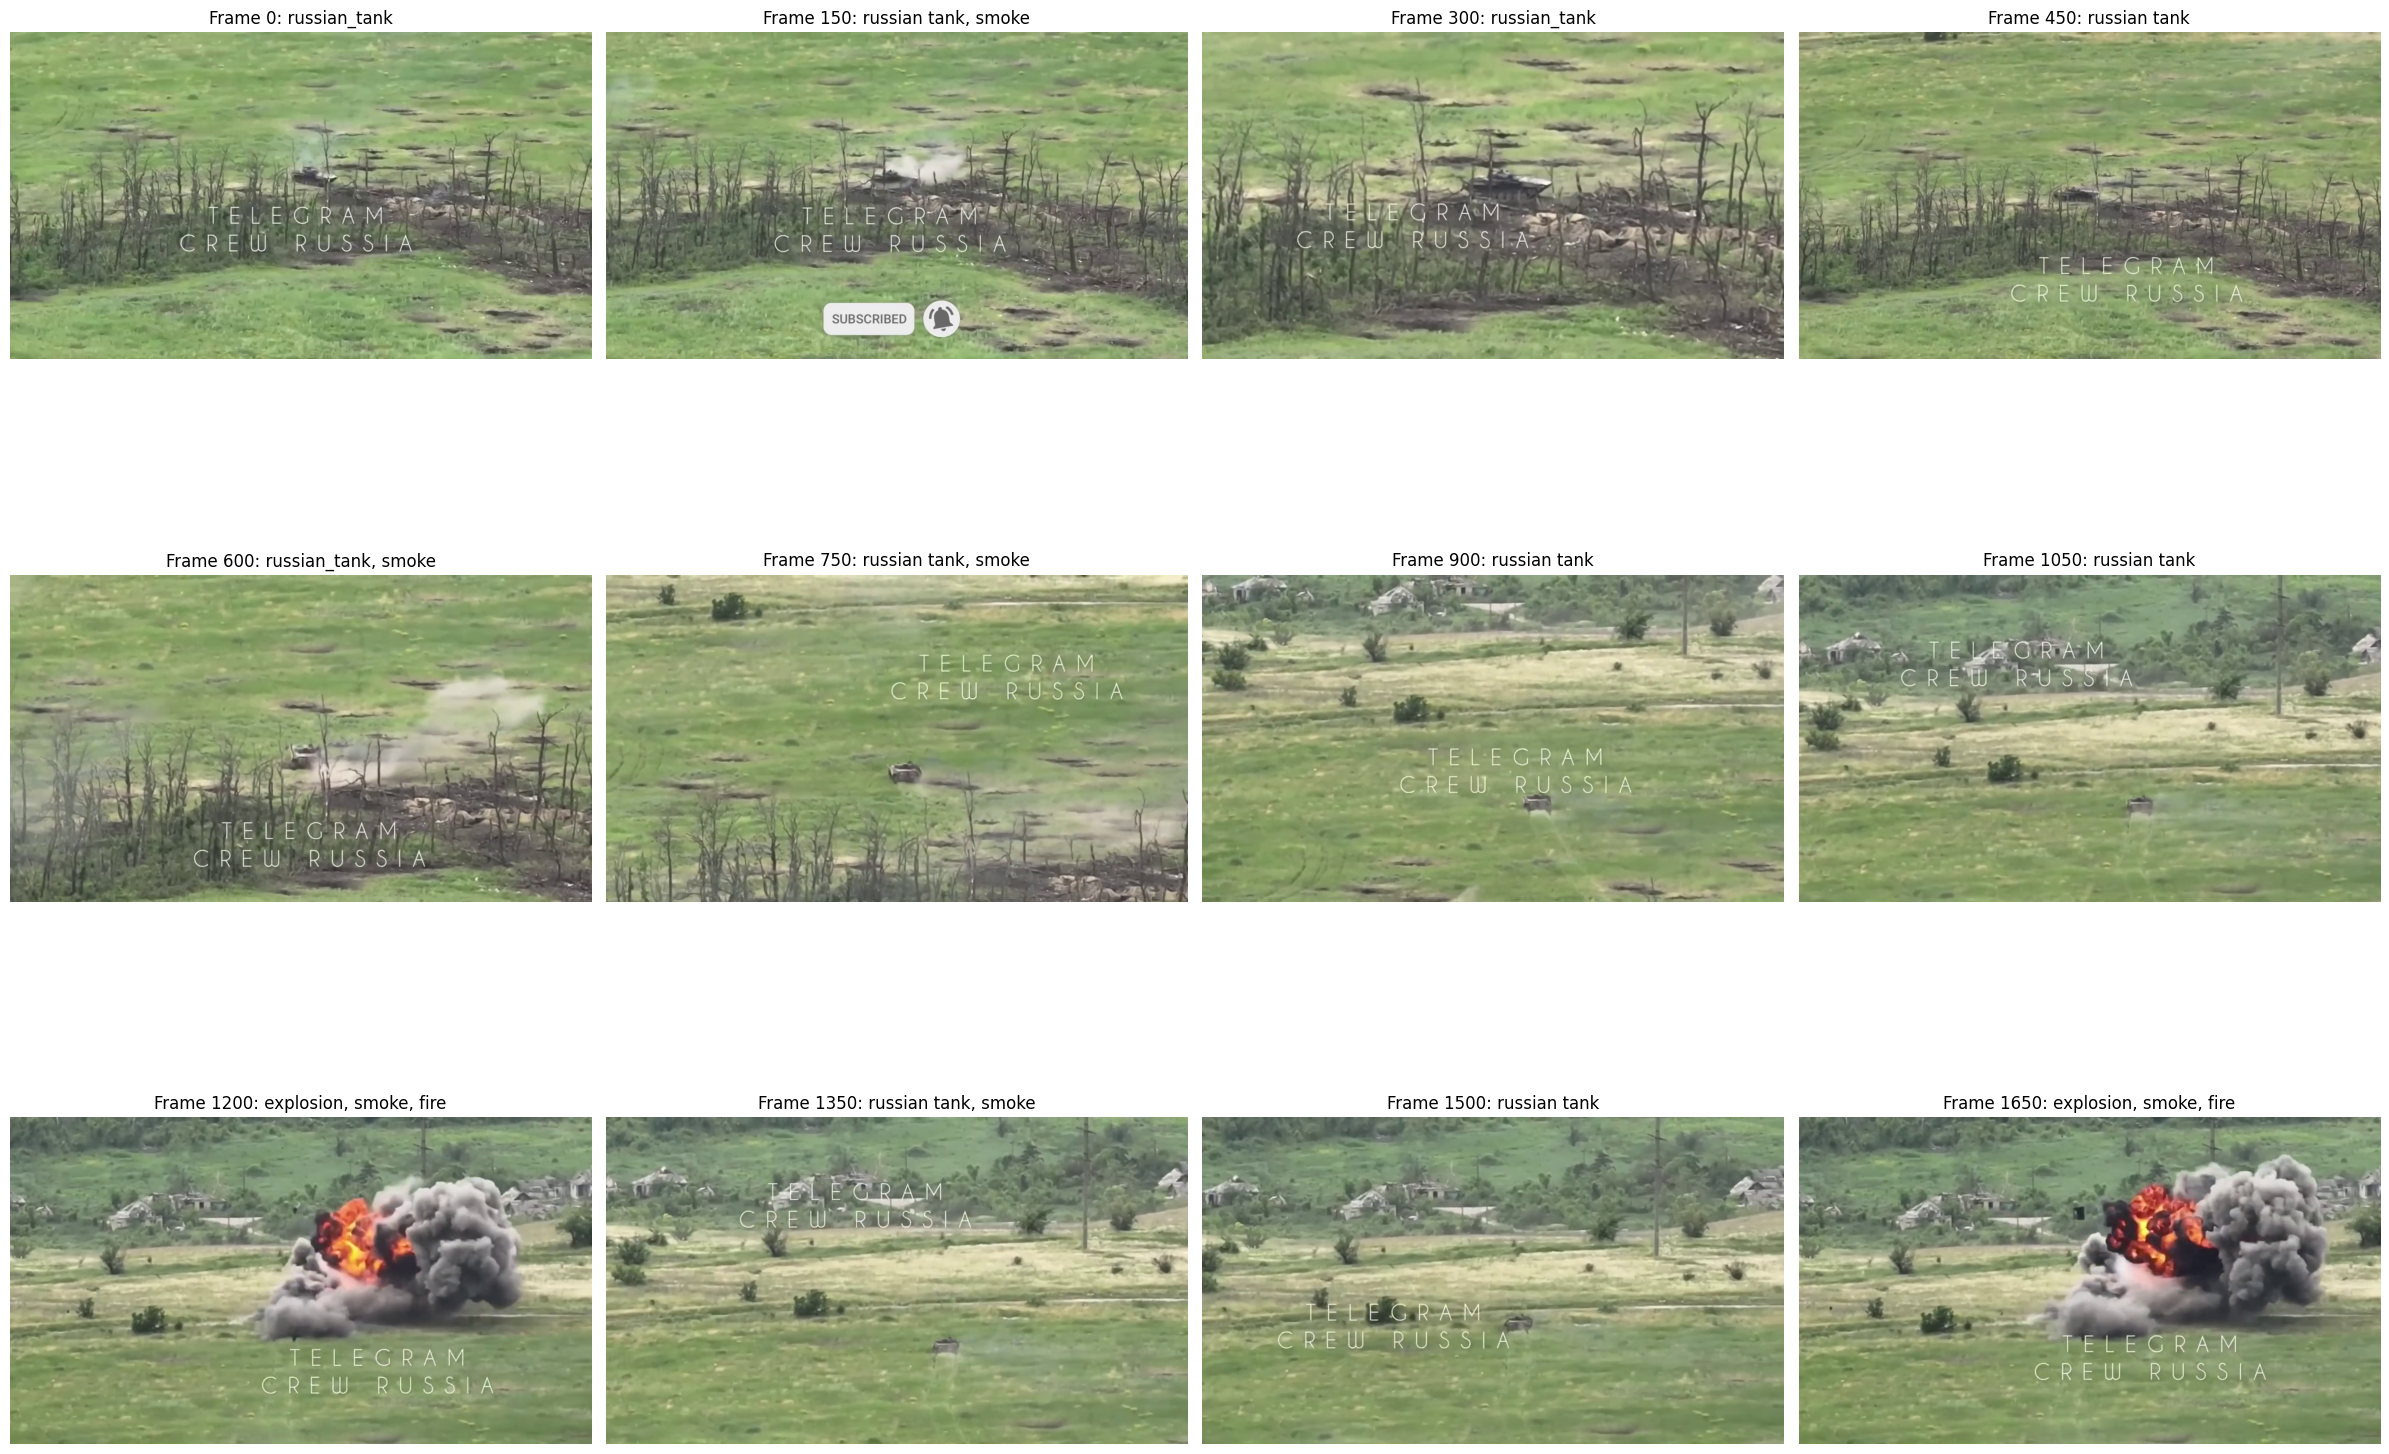